In [ ]:
import os
import csv
import pandas as pd
from datetime import datetime
import numpy as np
import time as t
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, f1_score
from sklearn.svm import SVC

In [ ]:
# загрузка обработанной таблицы shipments с синтетическими признаками, с признаками можно ознакомиться в preprocessing_shipments.py
df = pd.read_csv('test_data.csv')
df = df.drop('Unnamed: 0', axis = 1)
df.head(5)

,Unnamed: 0,phone_id,current_month,freq_m,freq_av,n_shipm_m,n_shipm_av,shipment_time_m,shipment_time_av,average_rate_m,average_rate_av,promo_total_m,promo_total_av,per_cent_canceled_m,per_cent_canceled_av,change_of_city,change_of_retailer,weight,os
0,0,3.0,4.0,0.5,0.5,2.0,2.0,22.0,22.0,5.0,5.0,0.0,0.0,0.0,0.0,1.0,1.0,0.156325,android
1,1,3.0,5.0,0.0,0.5,0.0,2.0,720.0,22.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.156325,5.0
2,2,3.0,6.0,1.0,1.1,1.0,3.0,50.0,54.4,1.0,2.0,-250.0,-250.0,0.0,0.0,1.0,1.0,0.094735,android
3,3,9.0,2.0,1.0,1.0,1.0,1.0,51.0,51.0,0.0,0.0,-150.0,-150.0,0.0,0.0,1.0,1.0,0.131200,windows
4,4,9.0,3.0,0.0,1.0,0.0,1.0,720.0,51.0,0.0,0.0,0.0,-150.0,0.0,0.0,0.0,0.0,0.131200,5.0


In [ ]:
ss

,Id,Predicted
0,19843,NaN
1,471287,NaN
2,342522,NaN
3,457799,NaN
4,233778,NaN
...,...,...
214604,16841,NaN
214605,69348,NaN
214606,594974,NaN
214607,320024,NaN


In [ ]:
# sample submission to follow the format
ss = pd.read_csv('sample_submission.csv', ';')
len(ss)

214609

In [ ]:
# small cleaning in the df

df = df.drop(['per_cent_canceled_m', 'per_cent_canceled_av'], axis = 1)
df['os'] = df['os'].astype('str')

le = LabelEncoder()
df['os'] = le.fit_transform(df['os'])


for feat in ['phone_id', 'current_month', 'n_shipm_m', 'n_shipm_av']:
    df[feat] = df[feat].astype('int')
    
df

,phone_id,current_month,freq_m,freq_av,n_shipm_m,n_shipm_av,shipment_time_m,shipment_time_av,average_rate_m,average_rate_av,promo_total_m,promo_total_av,change_of_city,change_of_retailer,weight,os
0,3,4,0.5,0.5,2,2,22.0,22.0,5.0,5.0,0.0,0.0,1.0,1.0,0.156325,1
1,3,5,0.0,0.5,0,2,720.0,22.0,0.0,5.0,0.0,0.0,0.0,0.0,0.156325,0
2,3,6,1.0,1.1,1,3,50.0,54.4,1.0,2.0,-250.0,-250.0,1.0,1.0,0.094735,1
3,9,2,1.0,1.0,1,1,51.0,51.0,0.0,0.0,-150.0,-150.0,1.0,1.0,0.131200,7
4,9,3,0.0,1.0,0,1,720.0,51.0,0.0,0.0,0.0,-150.0,0.0,0.0,0.131200,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370510,715237,5,1.0,1.0,1,1,46.0,46.0,5.0,5.0,-250.0,-250.0,1.0,1.0,0.173350,1
370511,715303,5,1.0,1.0,1,1,14.0,14.0,4.0,4.0,-250.0,-250.0,1.0,1.0,0.120800,1
370512,715416,5,0.5,0.5,2,2,31.0,31.0,0.0,0.0,-125.0,-250.0,1.0,1.0,0.159300,1
370513,715533,5,1.0,1.0,1,1,55.0,55.0,5.0,5.0,0.0,0.0,1.0,1.0,0.032670,1


In [ ]:
# load training data & merge with preprocesed shipments table
y = pd.read_csv('train/train.csv')
y = y.loc[y['phone_id'].isin(X['phone_id'].unique())]
X_ = y.merge(right = df, right_on = 'phone_id', left_on = 'phone_id')
X_ = X_.dropna(axis = 0)

In [ ]:

X_ = X_.drop(['order_completed_at'], axis = 1)
X_ = X_.drop_duplicates(['phone_id'], keep = 'last')
X_

,phone_id,target,current_month,freq_m,freq_av,n_shipm_m,n_shipm_av,shipment_time_m,shipment_time_av,average_rate_m,average_rate_av,promo_total_m,promo_total_av,change_of_city,change_of_retailer,weight,os
13,342522,0.0,2,1.000000,1.000000,1,1,4.000000,4.000000,0.0,0.000000,-200.00,-200.00,1.0,1.0,0.075150,7
16,233778,1.0,7,1.000000,1.200000,1,2,13.000000,17.400000,0.0,0.000000,0.00,0.00,1.0,1.0,-0.050650,3
22,40738,0.0,7,0.200000,0.253333,5,13,37.600000,42.680000,4.0,4.666667,0.00,-10.00,1.0,3.0,0.241056,7
26,174054,1.0,7,1.000000,1.220000,1,4,28.000000,38.680000,0.0,0.000000,0.00,-60.00,1.0,1.0,0.460110,1
31,155699,1.0,7,0.333333,0.533333,3,4,19.333333,25.133333,1.0,1.600000,0.00,0.00,1.0,2.0,-0.126877,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615672,222552,1.0,7,1.000000,1.100000,1,3,32.000000,34.500000,0.0,1.000000,0.00,0.00,1.0,1.0,-0.049485,2
615675,238680,0.0,7,1.000000,1.066667,1,4,34.000000,38.600000,5.0,5.933333,-500.00,-589.80,1.0,1.0,-0.193467,2
615678,16841,1.0,7,0.333333,0.433333,3,5,15.666667,26.166667,5.0,5.800000,0.00,0.00,1.0,1.0,0.209512,2
615681,69348,0.0,7,1.000000,1.066667,1,4,26.000000,31.666667,5.0,6.000000,0.00,-50.00,1.0,1.0,-0.068153,2


In [ ]:
y = X_['target']
X_ = X_.drop(['target'], axis = 1)

In [ ]:
X_test = X_test.drop_duplicates(['phone_id'], keep = 'last', ignore_index = True)
len(X_test)

151294

In [ ]:
X = X_
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, f1_score
from sklearn.svm import SVC

/anaconda3/envs/CS456/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Mean : 0.8084977271675885
STD : 0.002085686681872576


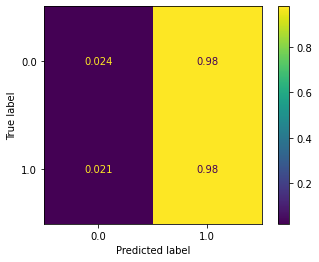

In [ ]:
model = LogisticRegression()
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(model, X_train, y_train, scoring='f1', cv=cv, n_jobs=1)
print('Mean : {}\nSTD : {}'.format(scores.mean(), scores.std()))
model.fit(X_train, y_train)
plot_confusion_matrix(model, X_test, y_test, normalize = 'true')

Mean : 0.780980130034249
STD : 0.0017516878591214004


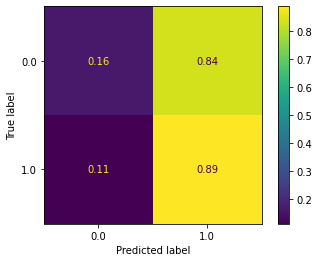

In [ ]:
model2 = RandomForestClassifier(65)
model2.fit(X_train, y_train)
scores = cross_val_score(model2, X_train, y_train, scoring='f1', cv=cv, n_jobs=1)
print('Mean : {}\nSTD : {}'.format(scores.mean(), scores.std()))
model2.fit(X_train, y_train)
plot_confusion_matrix(model2, X_test, y_test, normalize = 'true')

In [ ]:
model3 = SVC( kernel = 'poly')
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(model3, X_train, y_train, scoring='f1', cv=cv, n_jobs=1)
print('Mean : {}\nSTD : {}'.format(scores.mean(), scores.std()))
model3.fit(X_train, y_train)
plot_confusion_matrix(model3, X_test, y_test, normalize = 'true')

In [ ]:
unic = ss['Id'].unique()
print(len(unic))
X_sub = X_.loc[X_['phone_id'].isin(unic)]
len(X_sub)

In [ ]:
X_sub

choose one below

In [ ]:
y_pred = model2.predict(X_sub)

In [ ]:
y_pred = model2.predict(X_sub)

Write to required format

In [ ]:
res = pd.DataFrame(X_sub['phone_id'])
#res['Pred'] = y_pred
len(res)
res

In [ ]:
#res = res.drop('Pred', axis = 0)

In [ ]:
res['Pred'] = y_pred

In [ ]:
res

In [ ]:
subm = ss.merge(right = res, how = 'left', left_on = 'Id', right_on = 'phone_id', copy = False)

In [ ]:
214609 - subm['Pred'].isna().sum()

In [ ]:
subm['Predicted'] = subm['Pred']
subm

In [ ]:
subm = subm.drop(['phone_id', 'Pred'], axis = 1)

In [ ]:
rand = np.random.random((214609, 2))
rand = (rand > 0).astype('int')
rand = pd.DataFrame(rand, columns = subm.columns)

In [ ]:
subm2 = subm.fillna(rand)

In [ ]:
subm2

In [ ]:
subm2['Predicted'] = subm2['Predicted'].astype('int')
subm2.to_csv('subm5.csv', index = False)